# Initial Experiments w Hierarchical Attention Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a markov chain.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
x_1^{(t)} &\sim \mu, x_{i+1}^{(t)} \sim P(\cdot | x_i^{(t)})
\end{align*}
$$

In [1]:
import numpy as np
import utils

In [2]:
vocab_size = 10

# choose deterministic transition matrix
next_word = {0: 0, 1: 2, 2: 3, 3: 4, 4: 1, 5: 6, 6: 7, 7: 5, 8: 9, 9: 8}
transition_matrix = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    transition_matrix[i, next_word[i]] = 1


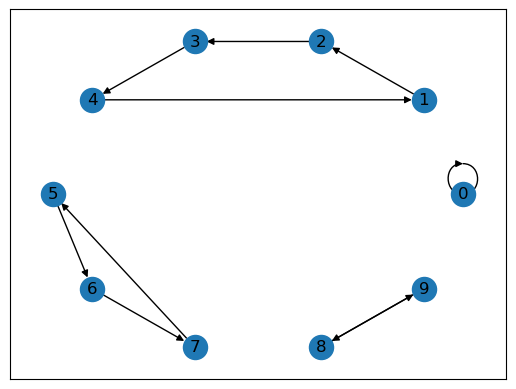

In [3]:
import networkx as nx
graph = nx.DiGraph(transition_matrix)
nx.draw_networkx(graph, with_labels=True, pos=nx.circular_layout(graph))

In [4]:
def sample_markov_chain(transition_matrix, initial_state, num_steps):
    current_state = initial_state
    states = [current_state]
    for i in range(num_steps-1):
        probabilities = transition_matrix[current_state, :]
        next_state = np.random.choice(len(probabilities), p=probabilities)
        states.append(next_state)
        current_state = next_state
    return states

In [5]:
mem_seq_len = 4
input_seq_len = 6

mem_seq_initial_states = list(range(vocab_size-3))
input_seqs_initial_states = list(range(vocab_size))

train_seqs = np.array([sample_markov_chain(transition_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
train_seqs_x = train_seqs[:, :-1]
train_seqs_y = train_seqs[:, 1:]

mem_seqs = np.array([sample_markov_chain(transition_matrix, initial_state, mem_seq_len + 1) for initial_state in mem_seq_initial_states])
mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=len(train_seqs))
mem_seqs_x = mem_seqs[:, :, :-1]
mem_seqs_y = mem_seqs[:, :, 1:]


In [6]:
print(f'train_seqs_x.shape: {train_seqs_x.shape}; train_seqs_y.shape: {train_seqs_y.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x.shape: {mem_seqs_x.shape}; mem_seqs_y.shape: {mem_seqs_y.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

train_seqs_x.shape: (10, 6); train_seqs_y.shape: (10, 6)
mem_seqs_x.shape: (10, 7, 4); mem_seqs_y.shape: (10, 7, 4)


In [7]:
mem_seqs_x[0]

array([[0, 0, 0, 0],
       [1, 2, 3, 4],
       [2, 3, 4, 1],
       [3, 4, 1, 2],
       [4, 1, 2, 3],
       [5, 6, 7, 5],
       [6, 7, 5, 6]])

In [8]:
train_seqs_x

array([[0, 0, 0, 0, 0, 0],
       [1, 2, 3, 4, 1, 2],
       [2, 3, 4, 1, 2, 3],
       [3, 4, 1, 2, 3, 4],
       [4, 1, 2, 3, 4, 1],
       [5, 6, 7, 5, 6, 7],
       [6, 7, 5, 6, 7, 5],
       [7, 5, 6, 7, 5, 6],
       [8, 9, 8, 9, 8, 9],
       [9, 8, 9, 8, 9, 8]])

## Hierarchical Attention Model

**Attend within each sequence in memory**

For $t \in [n_m]$,
$$\tilde{m}_i^{(t)} \gets \mathrm{CrossAttn}(Q \gets x_i, K \gets x^{(t)}, V \gets y^{(t)})$$

i.e.,

$$
\begin{align*}
\alpha_{ij}^{(t)} &\gets \mathrm{Softmax}([\langle \phi_Q (x_i), \phi_K (x_j^{(t)}) \rangle]_{j \in [[l]]})\\
\tilde{m}_i^{(t)} &\gets \sum_j \alpha_{ij}^{(t)} \phi_V(y_j^{(t)}) = \sum_{j} \alpha_{ij}^{(t)} \phi_V(x_{j+1}^{(t)})
\end{align*}
$$

**Attend over sequences in memory**
$$\alpha_{it} \gets \mathrm{Softmax}([\max_{j} \langle \phi_Q(x_i), \phi_K(x_j^{(t)}) \rangle]_{t \in [n_m]})$$

($\phi_Q, \phi_K$ can be the same as above.)

**Fetch vector from memory**
$$\tilde{m}_i \gets \sum_t \alpha_{it} \tilde{m}_i^{(t)} = \sum_t \sum_j \alpha_{it} \alpha_{ij}^{(t)} \phi_V(x_{j+1}^{(t)})$$

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from hierarchical_attention import HierarchicalAttention

### Define Memory Model

In [10]:

class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.hierarchical_mem_attention = HierarchicalAttention(
            key_dim, value_dim=embedding_dim, 
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')
        self.output_dense = layers.Dense(vocab_size, name='output')

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [11]:
memory_model = MemoryModel(vocab_size, embedding_dim=vocab_size, key_dim=vocab_size, name='memory_model')
memory_model([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=5e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  100       
                                                                 
 mem_attn (HierarchicalAtten  multiple                 300       
 tion)                                                           
                                                                 
 output (Dense)              multiple                  110       
                                                                 
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x, mem_seqs_y), train_seqs_y)).batch(4)

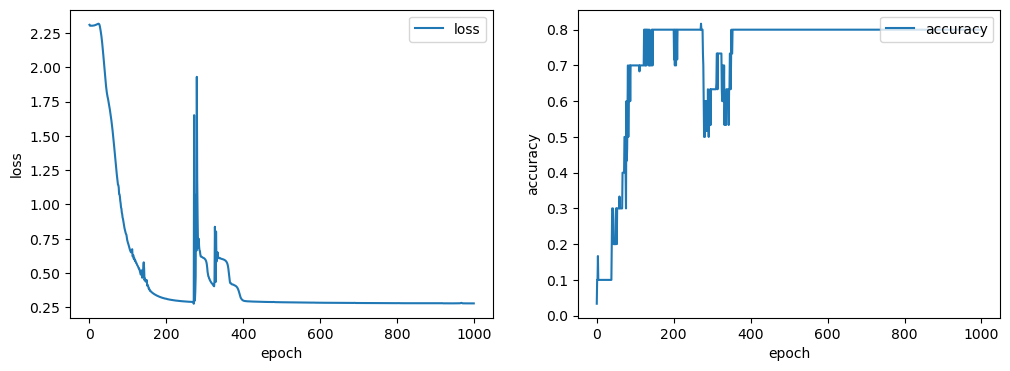

In [13]:
history = memory_model.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [14]:
memory_model.evaluate(train_ds)

3/3 [==============================] - 0s 2ms/step - loss: 0.2792 - accuracy: 0.8000


[0.279155433177948, 0.800000011920929]

### Analyze Hierarchical Attention Mechanism

In [15]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    fig, ax = plt.subplots()
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


#### Example 1: relevant memory exists in buffer (using the same memory buffer as during training)

Testing the sequence $(1, 2, 3, 4, 1, 2)$ with the same memory buffer that appeared in the training set. The model makes the correct prediction and attends to the correct sequences in memory.

In [16]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1]
sample_mem_seq_y = mem_seqs_y[b:b+1]
print(sample_input[0])
print(sample_mem_seq_x[0])

[1 2 3 4 1 2]
[[0 0 0 0]
 [1 2 3 4]
 [2 3 4 1]
 [3 4 1 2]
 [4 1 2 3]
 [5 6 7 5]
 [6 7 5 6]]


In [17]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[2 3 3 1 2 3]]
[2 3 4 1 2 3]
[[ True  True False  True  True  True]]


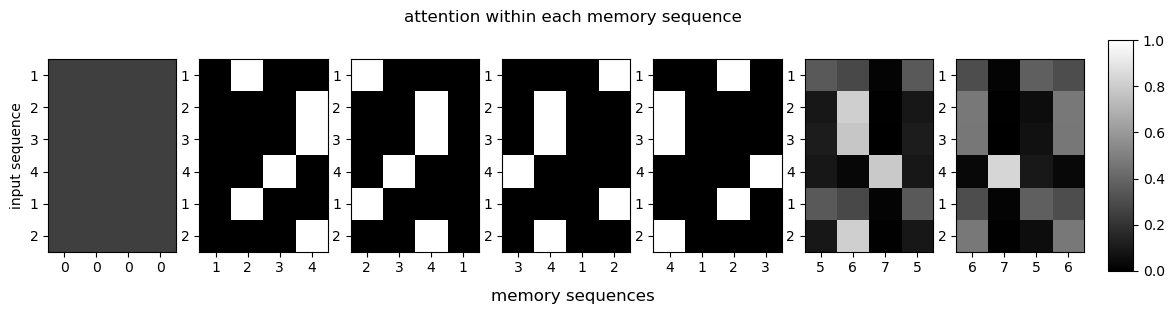

In [18]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

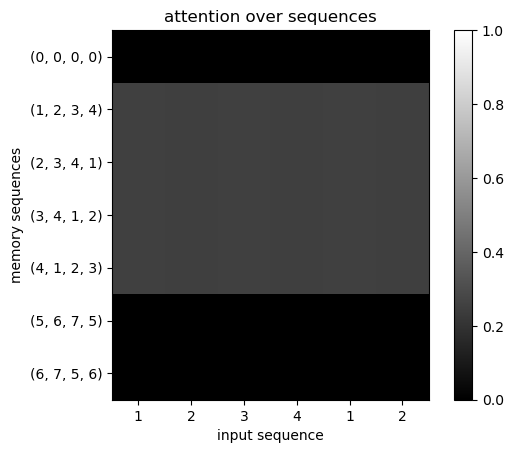

In [19]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 2: relevant memory exists in buffer (different memory buffer to one used in training)

We test on a smaller buffer which is different to the full buffer which was seen during training. The model still attends to the correct sequence and outputs the correct result.

In [20]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1, [0, 1, -2, -1]]
sample_mem_seq_y = mem_seqs_y[b:b+1, [0, 1, -2, -1]]
print(sample_input[0])
print(sample_mem_seq_x[0])

[1 2 3 4 1 2]
[[0 0 0 0]
 [1 2 3 4]
 [5 6 7 5]
 [6 7 5 6]]


In [21]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[2 3 3 1 2 3]]
[2 3 4 1 2 3]
[[ True  True False  True  True  True]]


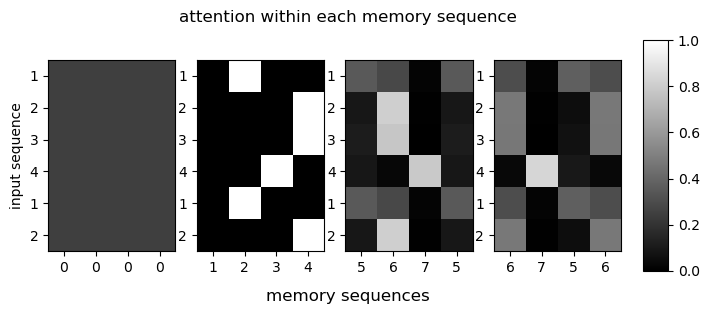

In [22]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

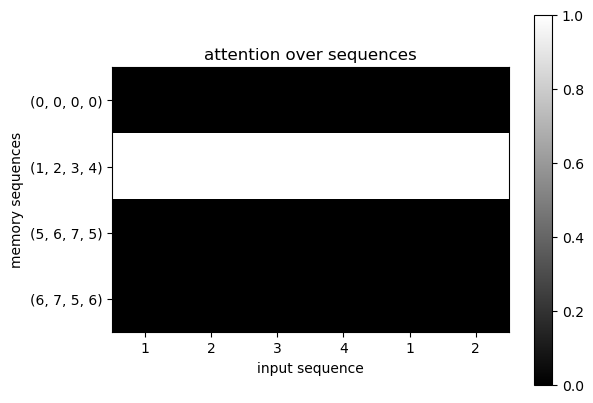

In [23]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 3: large memory buffer with many irrelevant sequences

We test on a larger memory buffer which contains many irrelevant sequences. The model is still able to retrieve the relevant memory and make a correct prediction.

In [24]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
n_reps_ = 5
mem_idxs =  [0] * n_reps_ + [1] + [-2] * n_reps_ + n_reps_ * [-1]
sample_mem_seq_x = mem_seqs_x[b:b+1, mem_idxs]
sample_mem_seq_y = mem_seqs_y[b:b+1, mem_idxs]
print(sample_input[0])
print(sample_mem_seq_x[0])

[1 2 3 4 1 2]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 2 3 4]
 [5 6 7 5]
 [5 6 7 5]
 [5 6 7 5]
 [5 6 7 5]
 [5 6 7 5]
 [6 7 5 6]
 [6 7 5 6]
 [6 7 5 6]
 [6 7 5 6]
 [6 7 5 6]]


In [25]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[2 3 3 1 2 3]]
[2 3 4 1 2 3]
[[ True  True False  True  True  True]]


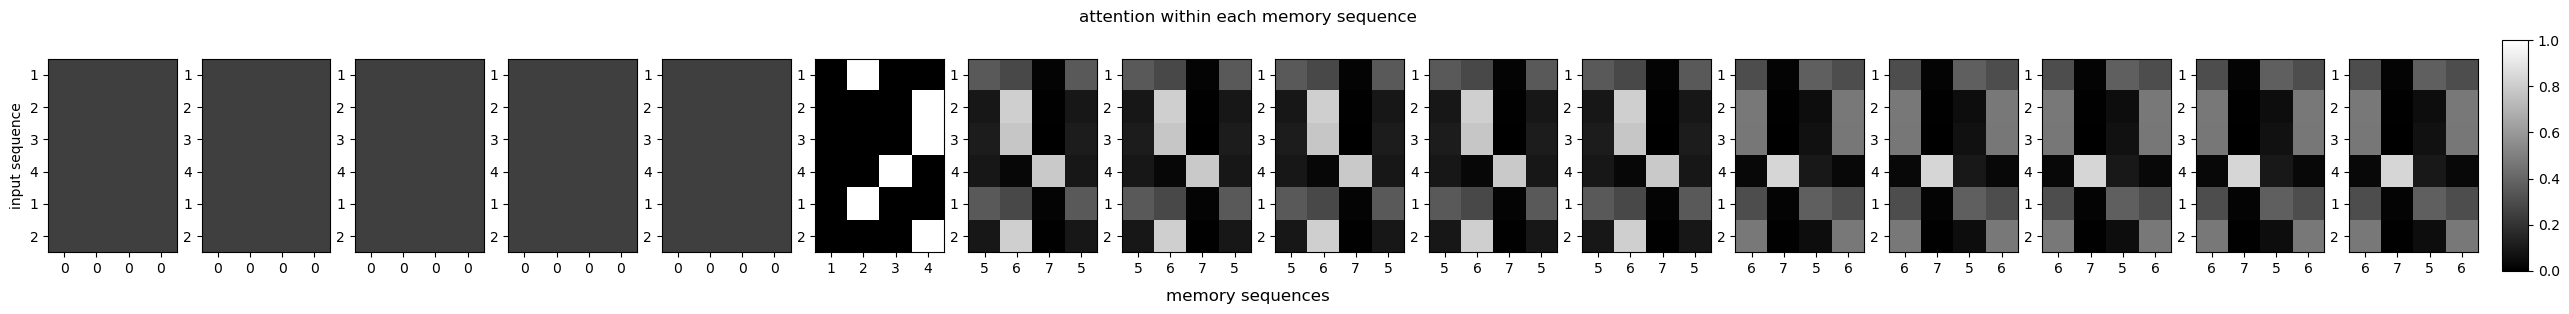

In [26]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

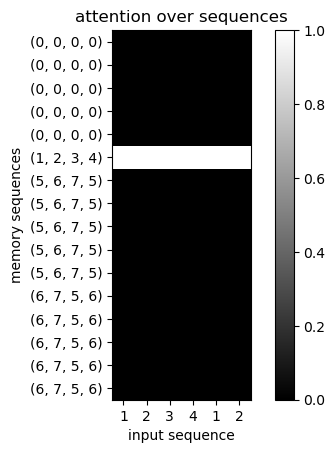

In [27]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 4: relevant memory does not exist in buffer; trained w expectation of relevant memory

The model was trained with the sequence $(1, 2, 3, 4, 1, 2)$ and relevant sequences in the memory buffer (e.g. the sequences $(1, 2, 3, 4)$, $(2, 3, 4, 1)$, etc.). When evaluated on the sequence but with a memory buffer containing only irrelevant information, the model fails.

In [28]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1, [0, -2, -1]]
sample_mem_seq_y = mem_seqs_y[b:b+1, [0, -2, -1]]
print(sample_input[0])
print(sample_mem_seq_x[0])

[1 2 3 4 1 2]
[[0 0 0 0]
 [5 6 7 5]
 [6 7 5 6]]


In [29]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[1 6 6 1 1 6]]
[2 3 4 1 2 3]
[[False False False  True False False]]


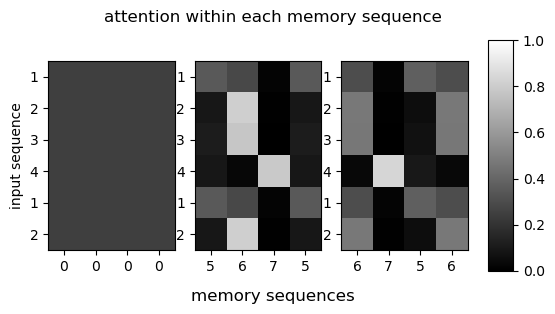

In [30]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

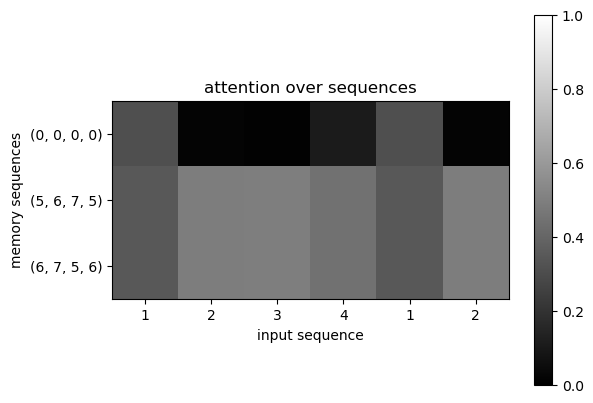

In [31]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 5: Generalization and drawing connections. no relevant memory in buffer, but trained without expectation of relevant memory in buffer

The sequence $(8, 9, 8, 9, 8, 9)$ appeared in the input sequences in the training dataset, but no relevant sequences where in the memory buffer during training (i.e., no sequences containing $8$ or $9$). The model is able to make the correct prediction regardless of the memory buffer given. It somehow learned to attend to the pattern in one particular sequence and used that to solve the sequences with $8$ and $9$ (the sequence with $1, 2, 3, 4$). In fact, if no sequence containing $(1, 2, 3, 4)$ is in the memory buffer, the model now fails! It is somehow using this other sequence to . (maybe it chose this sequence because the $8, 9$ sequence is a cycle of length 2 and the $(1,2,3,4)$ sequence is of length 4 (a multiple), which allows it to map $1, 3$ to $8$ and $2, 4$ to $9$ in order to generalize).

**With $(1,2,3,4)$ in memory buffer**

In [32]:
# choose sample input
b = 8
sample_input = train_seqs_x[b:b+1]

mem_idxs =  [0, 1, -2, -1, 0, 0]
sample_mem_seq_x = mem_seqs_x[b:b+1, mem_idxs]
sample_mem_seq_y = mem_seqs_y[b:b+1, mem_idxs]

print(sample_input[0])
print(sample_mem_seq_x[0])

[8 9 8 9 8 9]
[[0 0 0 0]
 [1 2 3 4]
 [5 6 7 5]
 [6 7 5 6]
 [0 0 0 0]
 [0 0 0 0]]


In [33]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[9 9 9 9 9 9]]
[9 8 9 8 9 8]
[[ True False  True False  True False]]


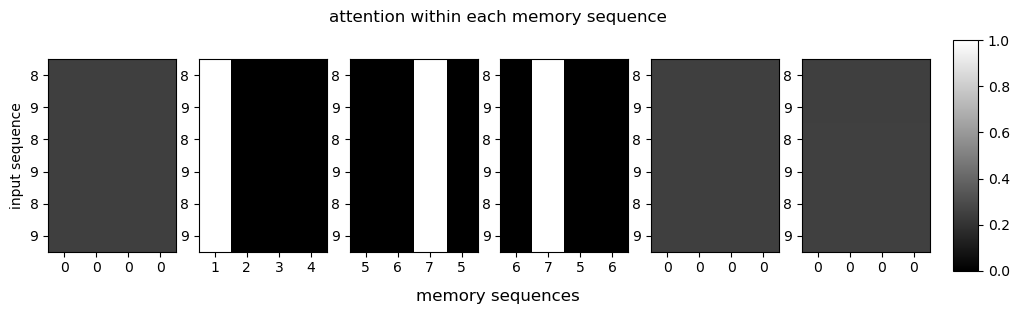

In [34]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

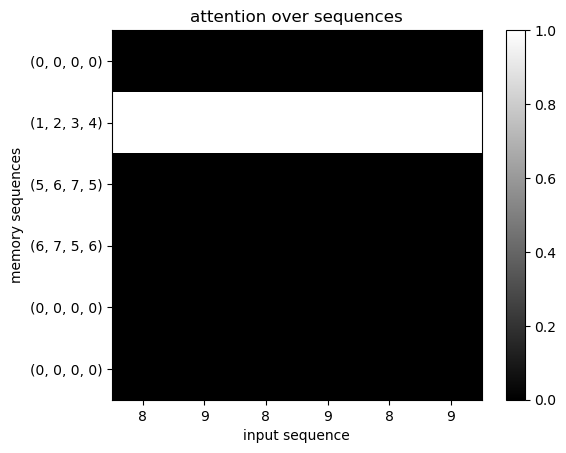

In [35]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

**Without $(1,2,3,4)$ in memory buffer**

In [36]:
# choose sample input
b = 8
sample_input = train_seqs_x[b:b+1]

mem_idxs =  [0, -2, -1, 0, 0]
sample_mem_seq_x = mem_seqs_x[b:b+1, mem_idxs]
sample_mem_seq_y = mem_seqs_y[b:b+1, mem_idxs]

print(sample_input[0])
print(sample_mem_seq_x[0])

[8 9 8 9 8 9]
[[0 0 0 0]
 [5 6 7 5]
 [6 7 5 6]
 [0 0 0 0]
 [0 0 0 0]]


In [37]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred) # the pattern in the mistake is interesting! it seems to have mapped between these sequences somehow
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[1 1 1 1 1 1]]
[9 8 9 8 9 8]
[[False False False False False False]]


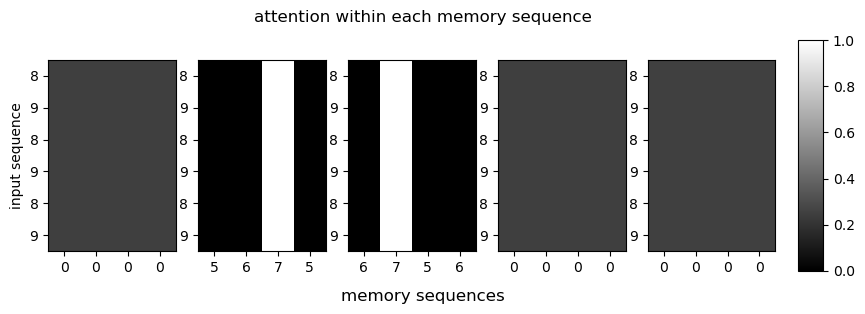

In [38]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

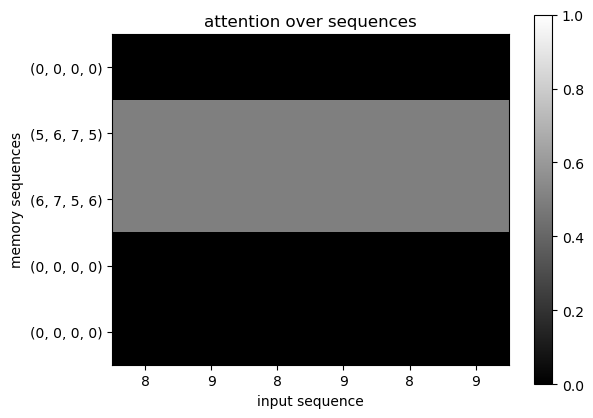

: 

In [39]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

# Notes:
- This model supports dynamic memory sizes
- Sequences in memory can be a different length from input sequences
- Hierarchical Attention module computes attention tensors at two different levels of hierarchy.
    1) per-sequence attention tensor (attends over each sequence in memory individually). shape: $l_{in} \times n_m \times l_m$
    2) over-sequence attention matrix (attend over *sequences* in memory). shape: $l_{in} \times n_m$
- there are some variations trial-to-trial. But the general pattern is similar. In particular, there is more variation in the attention matrices with each sequence independently. The attention *over* sequences is relatively stable trial-to-trial. Since each sequence is part of a cycle, the sequences are very distinct from each other, but the tokens within each cycle are more 'similar' to the model.
- The link between the $(8, 9)$ cycle and the $(1,2,3,4)$ cycle seems to hold robustly over different trials (although the particular solution found can vary).